In [1]:
import os
os.getcwd()

os.chdir('./rsna-pneumonia-detection-challenge/')

In [2]:
!ls

GCP Credits Request Link - RSNA.txt  stage_2_test_images       test_jpg
stage_2_detailed_class_info.csv      stage_2_train_images      train_jpg
stage_2_sample_submission.csv	     stage_2_train_labels.csv


In [3]:
# Extracting data and exploring

In [4]:
import pydicom
import os,pylab
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm


In [5]:
labels = pd.read_csv('stage_2_detailed_class_info.csv')

In [6]:
labels.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [7]:
labels.shape

(30227, 2)

In [8]:
# NO OF UNIQUE PATIENTS
labels['patientId'].nunique()

26684

In [9]:
labels.groupby('class').count()

,patientId
class,
Lung Opacity,9555
No Lung Opacity / Not Normal,11821
Normal,8851


The labels show that their are 9555 patients with pneumonia , 11821 with other problems but not pneumonia and 8851 as normal

In [10]:
train_labels=pd.read_csv('stage_2_train_labels.csv')

In [11]:
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [12]:
train_labels.groupby('Target').count()

,patientId,x,y,width,height
Target,,,,,
0,20672,0,0,0,0
1,9555,9555,9555,9555,9555


Target 1 means pneumonia or Lung opacity for others it is zero

In [13]:
train_data = pd.merge(left=train_labels,right=labels,on='patientId')

In [14]:
train_data.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [15]:
train_data.groupby('class').count()

,patientId,x,y,width,height,Target
class,,,,,,
Lung Opacity,16957,16957,16957,16957,16957,16957
No Lung Opacity / Not Normal,11821,0,0,0,0,11821
Normal,8851,0,0,0,0,8851


Lets look at the X-ray images one for target value 0 and one for target value 1
from train_labels.head() abve the 0 and 4th images we will see


Filename.........: ./stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
Patient id.......: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

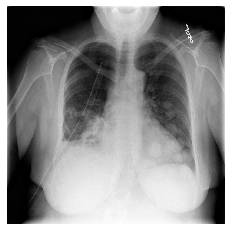

In [16]:
file = train_labels['patientId'][0]+'.dcm'
path = os.path.join('./stage_2_train_images/',file)
image = pydicom.dcmread(path)
print()
print("Filename.........:", path)
#print("class:",image.class)

print("Patient id.......:", image.PatientID)
img = image.pixel_array
print(img.shape)
pylab.imshow(img, cmap=pylab.cm.gist_gray)
pylab.axis('off')



Filename.........: ./stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm
Patient id.......: 00436515-870c-4b36-a041-de91049b9ab4


(-0.5, 1023.5, 1023.5, -0.5)

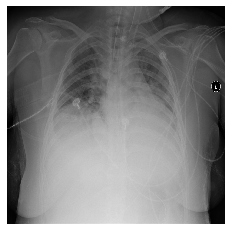

In [17]:
file = train_labels['patientId'][4]+'.dcm'
path = os.path.join('./stage_2_train_images/',file)
image = pydicom.dcmread(path)
print()
print("Filename.........:", path)


print("Patient id.......:", image.PatientID)

img = image.pixel_array
pylab.imshow(img, cmap=pylab.cm.gist_gray)
pylab.axis('off')


In [18]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': './stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [19]:
parsed = parse_data(train_labels)

In [20]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [21]:
print(parsed[train_labels['patientId'][4]])


{'dicom': './stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


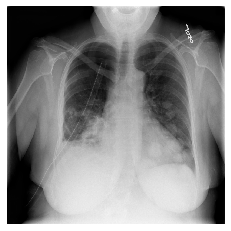

In [22]:
draw(parsed[train_labels['patientId'][0]])


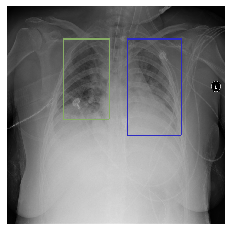

In [23]:
draw(parsed[train_labels['patientId'][4]])

In [27]:
if not os.path.exists('./train_jpg/'):
    os.mkdir('./train_jpg/')
    folder_path = './stage_2_train_images/'
    jpg_path = './train_jpg/'
    for idx,image in enumerate(path):
        img = pydicom.dcmread(os.path.join(folder_path,image))
        rows=[]
        img_pixel = img.pixel_array
        image = image.replace('.dcm','.jpg')
        cv2.imwrite(os.path.join(jpg_path,image),img_pixel)

folder_path = './stage_2_train_images/'
jpg_path = './train_jpg/'
path = os.listdir(folder_path)


In [28]:
if not os.path.exists('./test_jpg/'):
    os.mkdir('./test_jpg/')
    folder_path = './stage_2_test_images/'
    jpg_path = './test_jpg/'
    path = os.listdir(folder_path)
    for idx,image in enumerate(path):
        img = pydicom.dcmread(os.path.join(folder_path,image))
        rows=[]
        img_pixel = img.pixel_array
        image = image.replace('.dcm','.jpg')
        cv2.imwrite(os.path.join(jpg_path,image),img_pixel)

# Now we have Dicom data 
# We have test images and train images converted from .dcm to .jpg


In [31]:
# Let us see the shape of images in test dir for all jpg images
jpg_path = './test_jpg/'
path = os.listdir(jpg_path)
for idx , img in enumerate(path):
    img = cv2.imread(os.path.join(jpg_path,img))
    print(img.shape)

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1

In [41]:
from keras.applications import ResNet50,resnet50,dens
from keras.models import Sequential,Model
from keras_preprocessing import image
from keras.layers import Dense,Input,Conv2D,MaxPooling2D
import tensorflow as tf

In [43]:
# load the model
resnet_model = resnet50.ResNet50(weights = 'imagenet')

Exception: URL fetch failure on https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5 : None -- [Errno 110] Connection timed out